<a href="https://colab.research.google.com/github/eupshin/bootcamp/blob/main/5%EC%A1%B0_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_0615_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 데이터확장

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# 데이터 전처리
# add features 예제
# moving average
# window 정함 50
# 3sigma 정도로 limit 

def data_processing(case):

  num = case['num']
  filter = case['filter']
  circulation = case['circulation']
  purifier = case['purifier']
  # Github에서 데이터 읽기
  path = 'https://raw.githubusercontent.com/eupshin/BootCamp/main/'
  df_ca = pd.read_csv(path + 'ca' + num + '.csv')
  df_oa = pd.read_csv(path + 'oa' + num + '.csv')

  # CA,RA 데이터 정리
  size_ca = df_ca.shape[0]
  #print(num, ': ', size_ca)
  df_ca['time']=list(range(0,size_ca))
  df_ca = df_ca.drop('time1', axis=1)
  
  # OA 데이터 정리
  size_oa = df_oa.shape[0]
  #print(num, ' :', size_oa)
  #df_oa = df_oa[['OAPM10','OAPM2.5', 'OAPM1']]   
  df_oa = df_oa.drop('time2', axis=1)

  df_oa10 = pd.DataFrame(columns=['OAPM10','OAPM2.5', 'OAPM1'])
  for j in range(0,size_oa):
    for i in range(0,10):
      df_oa10.loc[i+j*10] = df_oa.loc[j][['OAPM10','OAPM2.5', 'OAPM1']]

  # 데이터(CA,RA,OA) 합치기
  df_con = pd.concat([df_ca,df_oa10],axis=1)

  # 운전조건(필터) 추가
  if filter == 'esp':
    df_con['filter_esp'] = 1
    df_con['filter_merv'] = 0
  else:
    df_con['filter_esp'] = 0
    df_con['filter_merv'] = 1

  # 운전조건(순환) 추가
  if circulation == 'ex':
    df_con['circulation_ex'] = 1
    df_con['circulation_in'] = 0
  else:
    df_con['circulation_ex'] = 0
    df_con['circulation_in'] = 1
  
  # 운전조건(공청기) 추가
  if purifier == 'off':
    df_con['purifier_off'] = 1
    df_con['purifier_on'] = 0
  else:
    df_con['purifier_off'] = 0
    df_con['purifier_on'] = 1
  
  return df_con

case11 = {'num':'1_1', 'filter':'esp', 'circulation':'ex', 'purifier':'off'}
df11 = data_processing(case11)

case12 = {'num':'1_2', 'filter':'esp', 'circulation':'ex', 'purifier':'on'}
df12 = data_processing(case12)

case21 = {'num':'2_1', 'filter':'esp', 'circulation':'in', 'purifier':'off'}
df21 = data_processing(case21)

case22 = {'num':'2_2', 'filter':'esp', 'circulation':'in', 'purifier':'on'}
df22 = data_processing(case22)

case32 = {'num':'3_2', 'filter':'merv', 'circulation':'ex', 'purifier':'off'}
df32 = data_processing(case32)

case41 = {'num':'4_1', 'filter':'merv', 'circulation':'in', 'purifier':'off'}
df41 = data_processing(case41)

case42 = {'num':'4_2', 'filter':'merv', 'circulation':'in', 'purifier':'on'}
df42 = data_processing(case42)

Text(0, 0.5, 'Concentration')

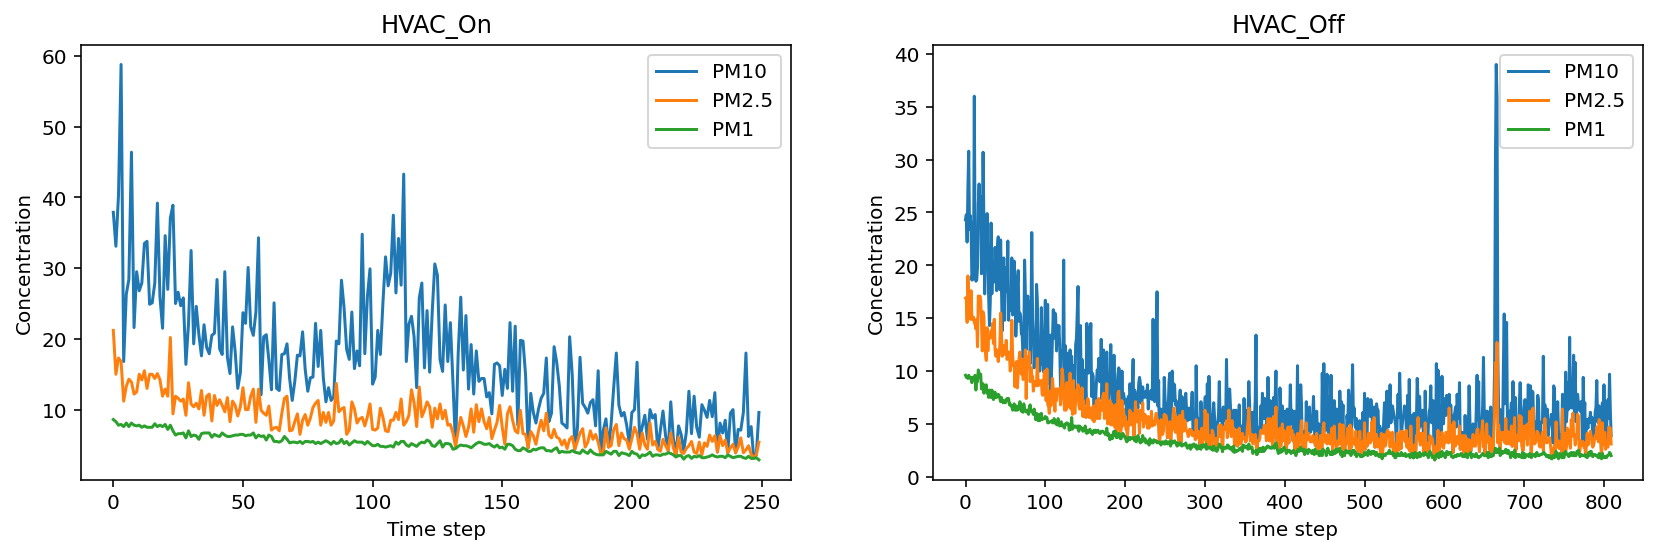

In [ ]:
plt.figure(figsize=(14,4))

df_p1 = df41
plt.subplot(1,2,1)
plt.plot(df_p1['time'], df_p1['CAPM10'])
plt.plot(df_p1['time'], df_p1['CAPM2.5'])
plt.plot(df_p1['time'], df_p1['CAPM1'])
plt.title('HVAC_On')
plt.legend(['PM10','PM2.5','PM1'])
plt.xlabel('Time step')
plt.ylabel('Concentration')

df_p2 = df42
plt.subplot(1,2,2)
plt.plot(df_p2['time'], df_p2['CAPM10'])
plt.plot(df_p2['time'], df_p2['CAPM2.5'])
plt.plot(df_p2['time'], df_p2['CAPM1'])
plt.title('HVAC_Off')
plt.legend(['PM10','PM2.5','PM1'])
plt.xlabel('Time step')
plt.ylabel('Concentration')

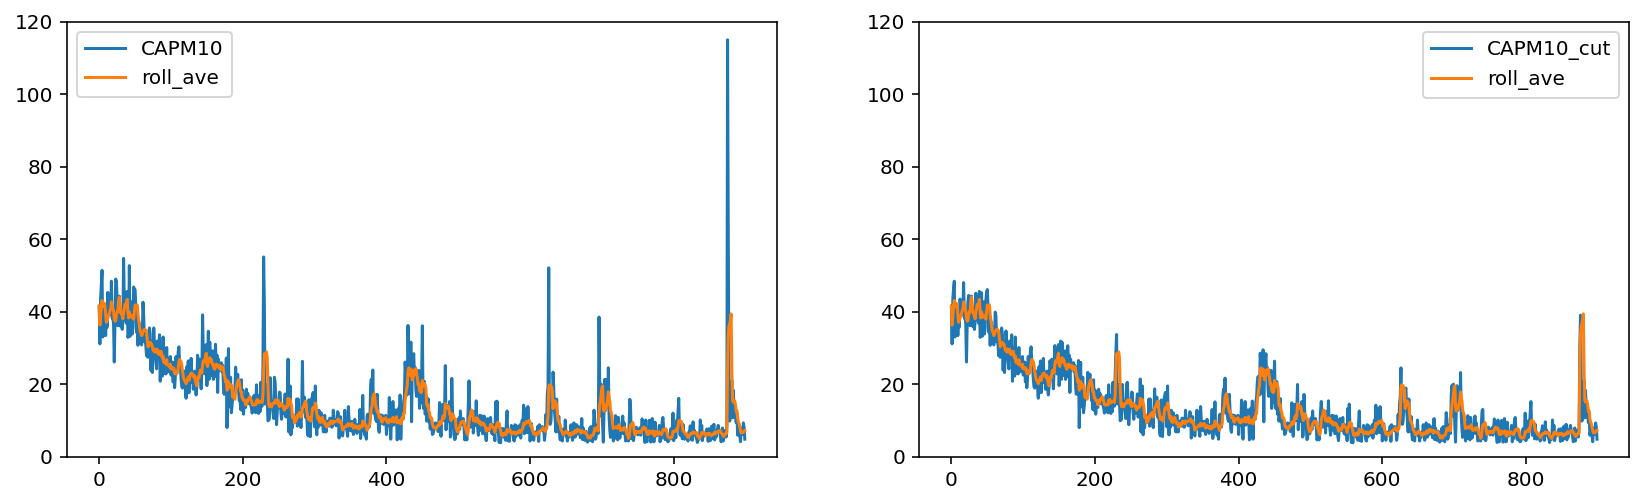

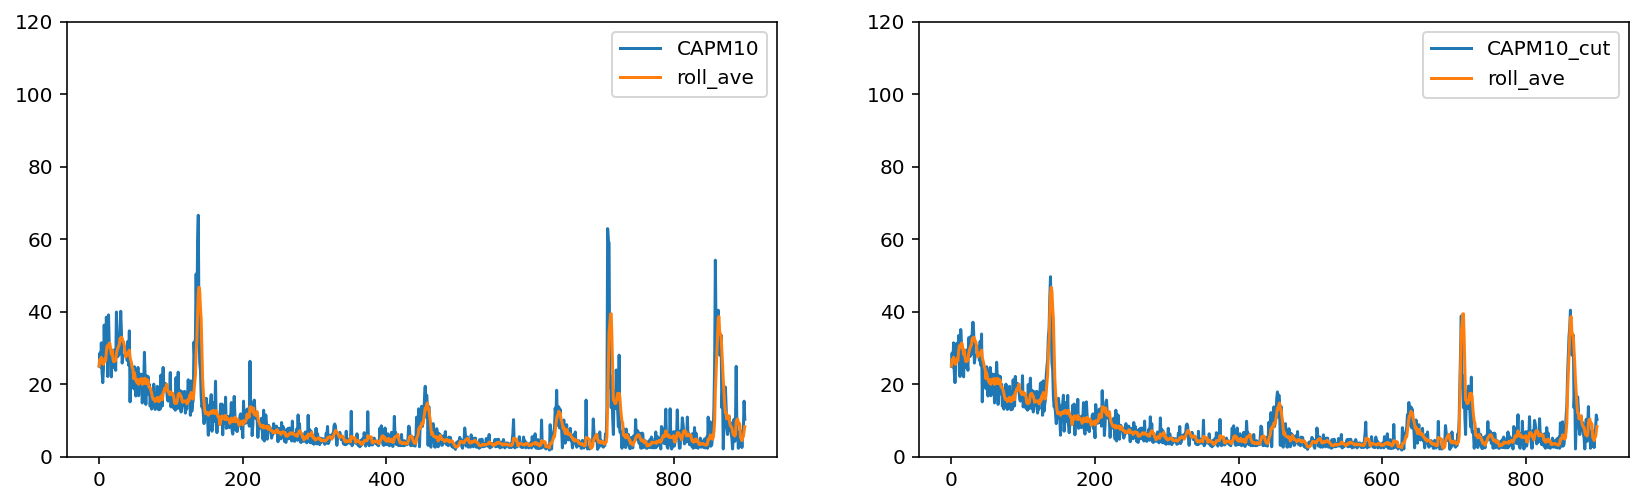

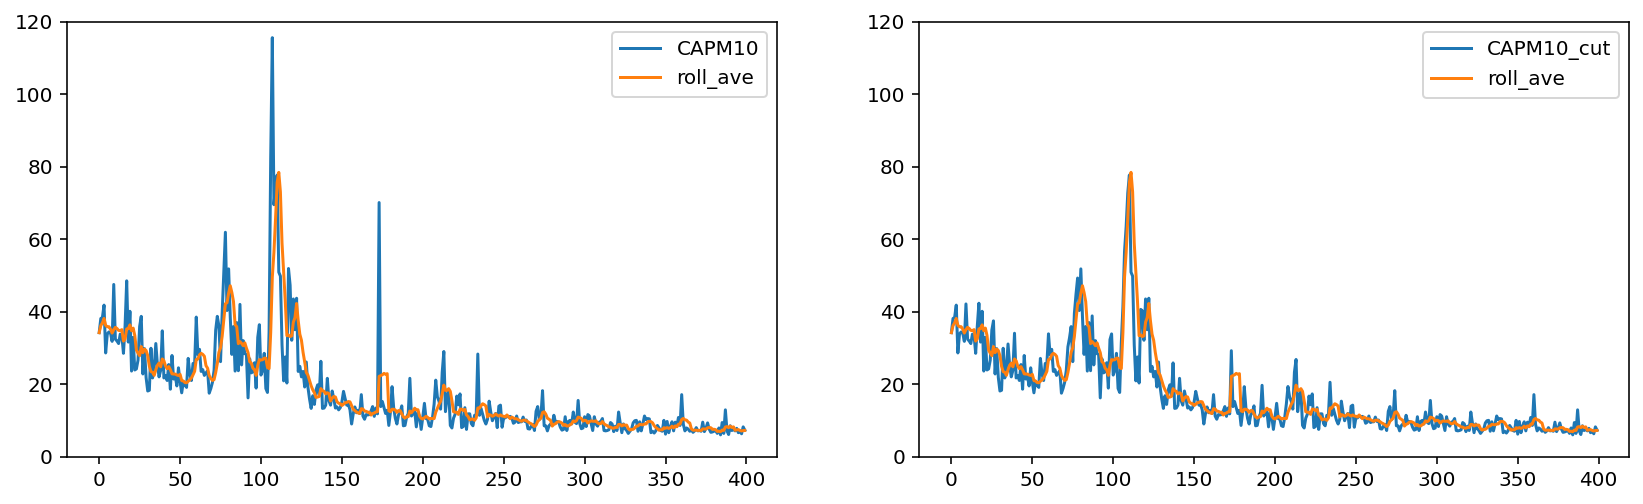

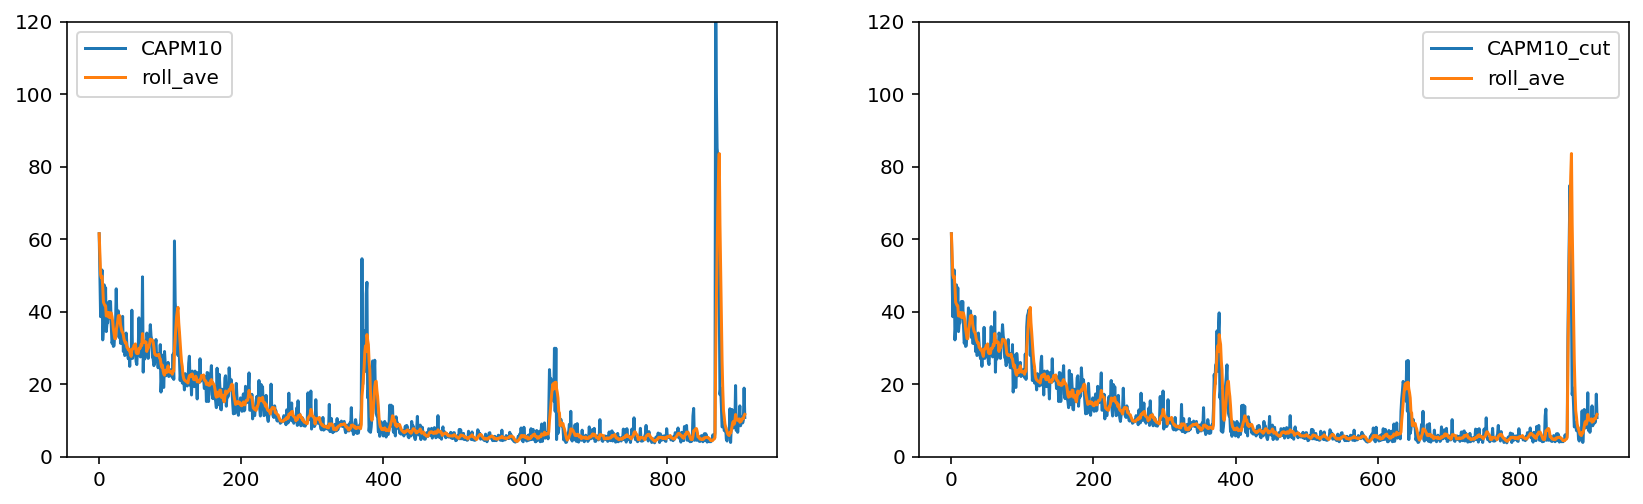

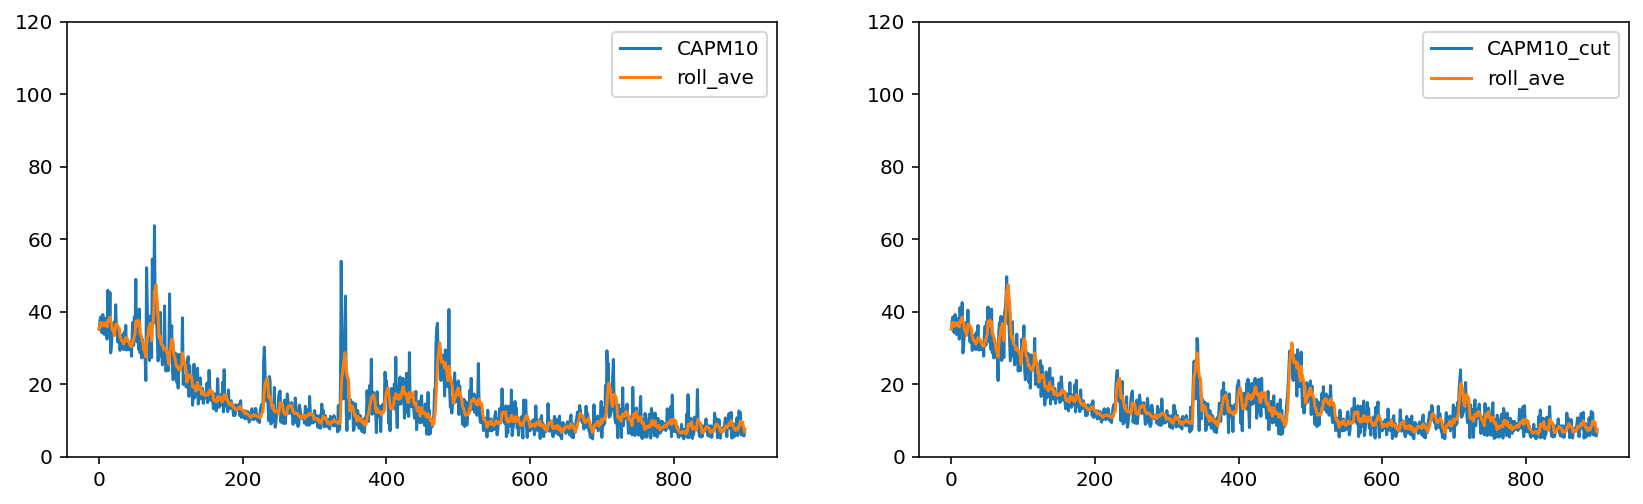

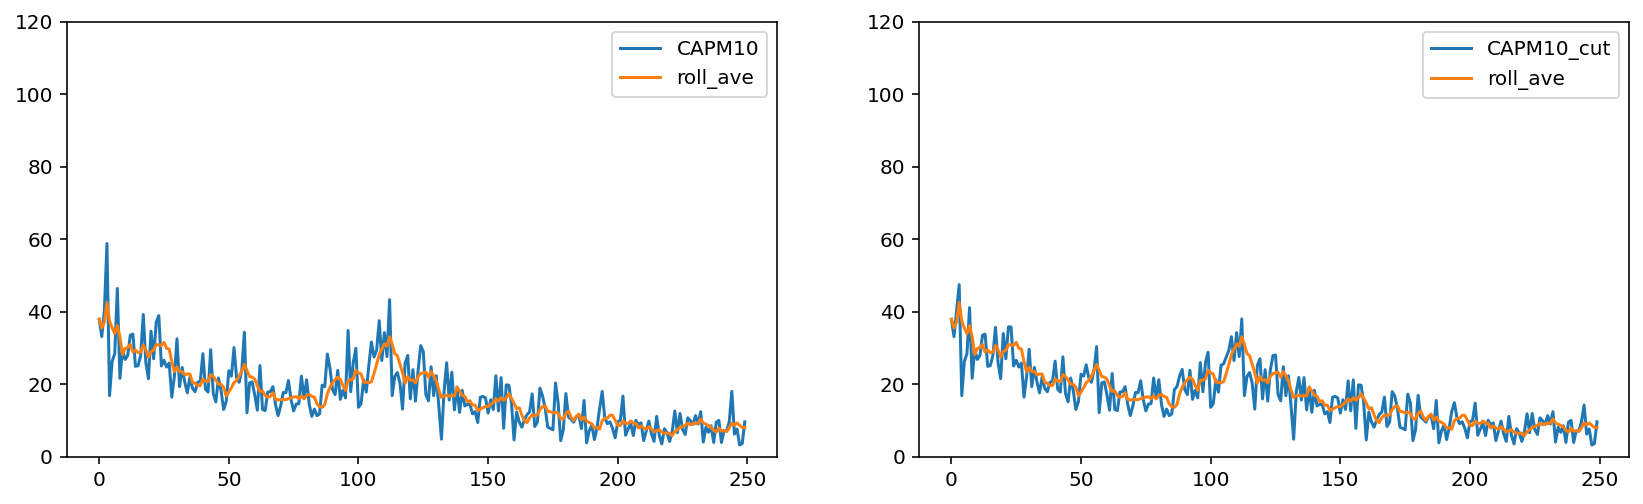

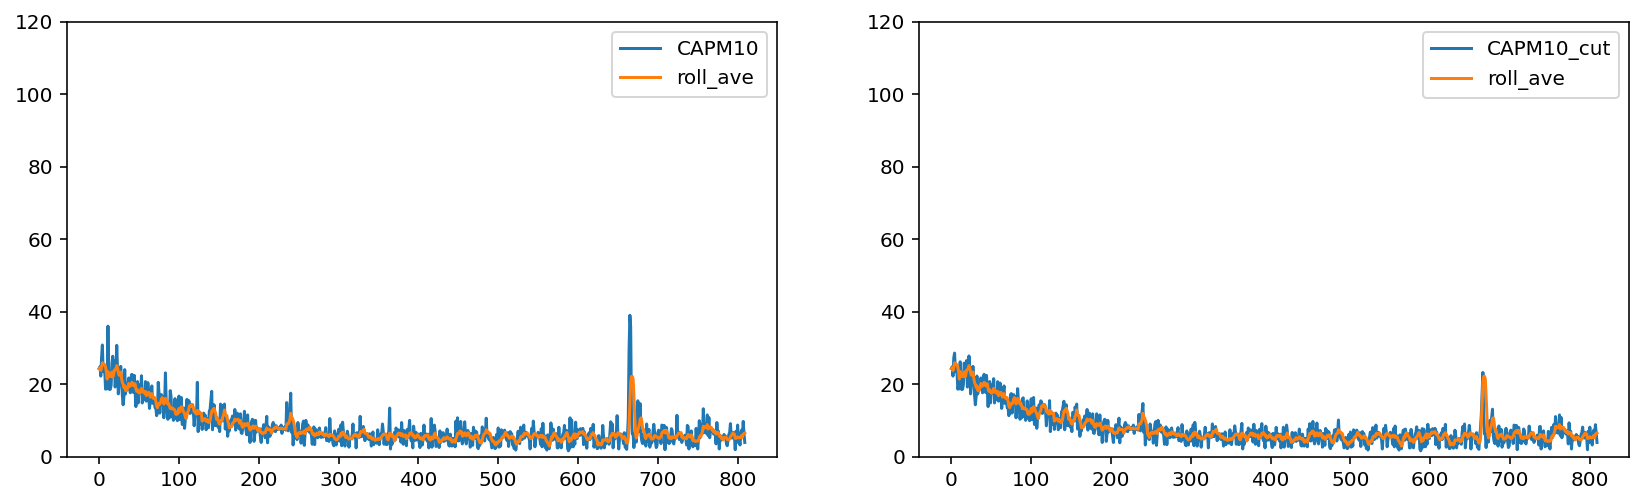

In [ ]:
# 이동평균을 이용하여 피크값 제거

def rolling_average(df, window):
  df_av = df.rolling(window, min_periods=1).mean()
  df_av.columns = [col + "_av" + str(window) for col in df.columns]
  return df_av

def cut_peak(df):

  # 이동평균 계산
  df['roll_ave'] = rolling_average(df[['CAPM10']], 6)

  # 표준편차 계산
  sigma = np.sqrt(np.sum((np.array(df[['CAPM10']]) - np.array(df[['roll_ave']]))**2) /df.shape[0])

  # 1*sigma 이상인 경우 제거하기
  sigma_level = 1

  camp10_cut = []
  for i in range(0,df.shape[0]):
    if df.iloc[i]['CAPM10'] - df.iloc[i]['roll_ave'] > sigma_level*sigma:
      #camp10_cut.append(df.iloc[i]['roll_ave'])
      camp10_cut.append(df.iloc[i]['roll_ave'] + sigma_level*sigma)
    else:
      #camp10_cut.append(df.iloc[i]['roll_ave'])
      camp10_cut.append(df.iloc[i]['CAPM10'])

  # 그래프 출력
  plt.figure(figsize=(14,4))

  plt.subplot(1,2,1)
  plt.plot(df['CAPM10'].values)
  plt.plot(df['roll_ave'].values)
  plt.legend(['CAPM10','roll_ave'])
  plt.ylim(0,120)

  plt.subplot(1,2,2)
  plt.plot(camp10_cut)
  plt.plot(df['roll_ave'].values)
  plt.legend(['CAPM10_cut','roll_ave'])
  plt.ylim(0,120)
  sigma

  df['CAPM10'] = camp10_cut

  return df 

df11 = cut_peak(df11)
df12 = cut_peak(df12)
df21 = cut_peak(df21)
df22 = cut_peak(df22)
df32 = cut_peak(df32)
df41 = cut_peak(df41)
df42 = cut_peak(df42)


In [ ]:
# t = t0일 때의 농도 값으로 t = t0 + 100일때의 농도 값을 예측 
# 학습데이터
# X           y
# data @ t=0  data @ t=10
# data @ t=1  data @ t=11
# data @ t=2  data @ t=12
# data @ t=3  data @ t=13


# 타임 스텝
time_step = 100

# 현재에서 몇% 떨어졌는지 추정
# shift할 때 

def create_xy1(df):
  size_df = df.shape[0]
  df_x = df[['CAPM10', 'CAPM2.5', 'CAPM1',
             'RAPM10', 'RAPM2.5', 'RAPM1',
             'OAPM10', 'OAPM2.5', 'OAPM1', 
             'filter_esp', 'filter_merv', 
             'circulation_ex', 'circulation_in', 
             'purifier_off', 'purifier_on']][:size_df-time_step]
  #df_y = df[['CAPM10', 'CAPM2.5', 'CAPM1', 
  #               'RAPM10', 'RAPM2.5', 'RAPM1']][time_step:size_df]
  df_y = df[['CAPM10','CAPM2.5', 'CAPM1']][time_step:size_df]
  
  return df_x, df_y


time_shift = 5
def create_xy2(df):
  size_df = df.shape[0]
  
  df_x = pd.DataFrame()
  df_y = pd.DataFrame()
  for i in range(0, size_df-time_step, time_shift):
    df_x = df_x.append(df[['CAPM10', 'CAPM2.5', 'CAPM1',
                           'RAPM10', 'RAPM2.5', 'RAPM1',
                           'OAPM10', 'OAPM2.5', 'OAPM1', 
                           'filter_esp', 'filter_merv', 
                           'circulation_ex', 'circulation_in', 
                           'purifier_off', 'purifier_on']][i:i+1])
    df_y = df_y.append(df[['CAPM10','CAPM2.5', 'CAPM1']][i+time_step:i+time_step+1])
  
  return df_x, df_y


# 학습 데이터 만들어서 합치기

create_xy = create_xy2

df_x, df_y = create_xy(df11)

df_x1, df_y1 = create_xy(df12)
df_x = pd.concat([df_x, df_x1]) 
df_y = pd.concat([df_y, df_y1])

df_x1, df_y1 = create_xy(df21)
df_x = pd.concat([df_x, df_x1]) 
df_y = pd.concat([df_y, df_y1])

df_x1, df_y1 = create_xy(df22)
df_x = pd.concat([df_x, df_x1]) 
df_y = pd.concat([df_y, df_y1])

df_x1, df_y1 = create_xy(df32)
df_x = pd.concat([df_x, df_x1]) 
df_y = pd.concat([df_y, df_y1])

df_x1, df_y1 = create_xy(df41)
df_x = pd.concat([df_x, df_x1]) 
df_y = pd.concat([df_y, df_y1])

df_x1, df_y1 = create_xy(df42)
df_x = pd.concat([df_x, df_x1]) 
df_y = pd.concat([df_y, df_y1])

df_x.shape, df_y.shape

((874, 15), (874, 3))

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# train, test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, random_state=9)

# 데이터 형식 변환
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# 학습 실시
rfr = RandomForestRegressor(n_estimators=20)
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.5326457184001009

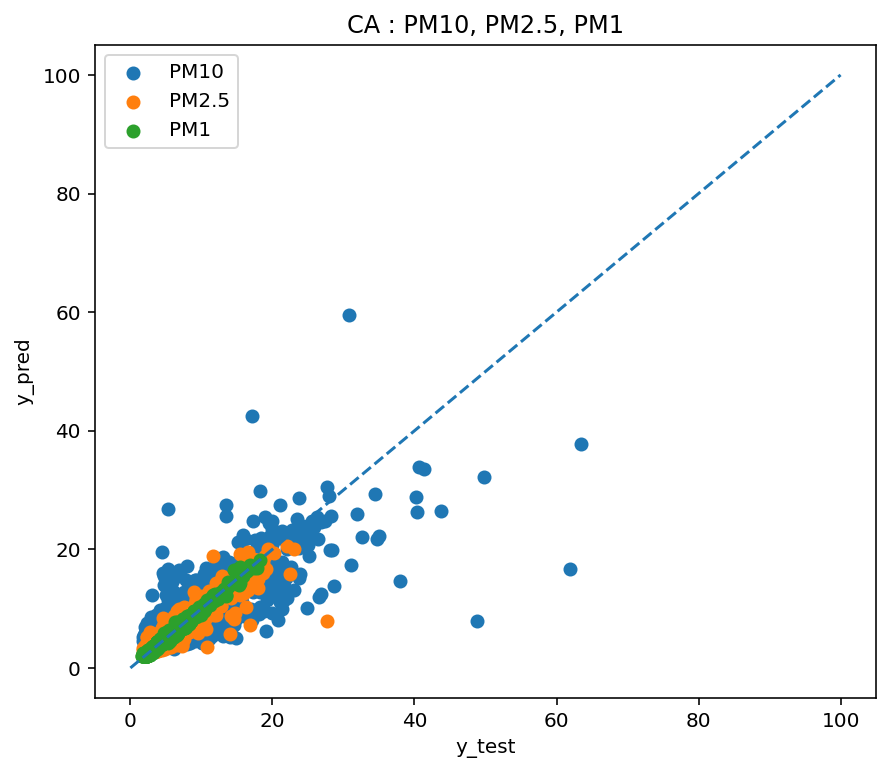

In [ ]:
# 실측, 예측 비교
y_pred = rfr.predict(X_test)

plt.figure(figsize=(7,6))
plt.scatter(y_test[:,0],y_pred[:,0])
plt.scatter(y_test[:,1],y_pred[:,1])
plt.scatter(y_test[:,2],y_pred[:,2])
plt.title('CA : PM10, PM2.5, PM1')
plt.legend(['PM10','PM2.5','PM1'])
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.plot([0,100],[0,100],'--')

In [ ]:
# t0 에서의 값으로 (t0+1) ~ (t0+10) 사이의 값을 예측
# 학습데이터
# X           y
# data @ t=0  data @ t=1~10
# data @ t=1  data @ t=2~11
# data @ t=2  data @ t=3~12
# data @ t=3  data @ t=4~13
#
# 만약에 t = (t0+1) ~ (t0+20) 사이의 값을 예측하고 싶다면
# 위의 학습으로 예측된 t0+10값을 X로 입력하여 다음 10개 time step 값을 예측함
# Sequential regression

# Linear Model(여러번 돌려야됨), MLP

# LSTM을 통한 시계열 예측, MLP의 depth가 있음